In [3]:
from __future__ import print_function
# Import the following modules:
%matplotlib inline

In [4]:
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

In [48]:
with open("data_train_20k.txt",'r',encoding='utf-8') as f:
    lines = f.read().split('\n')
    #remove enter
    lines[:] = [x for x in lines if x]

In [58]:
import string
result = string.punctuation

In [60]:
print(type(result))

<class 'str'>


In [68]:
import re
from nltk import tokenize, word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from autocorrect import spell
import nltk

snowball_stemmer = SnowballStemmer('english')
wordnet_lemmatizer = WordNetLemmatizer()

punctuation="#$%&'*+,-./:;<=>?@[\]^`{|}~"
def preprocess(text):
    sentence_tokens = sentence_tokenize(text)
    word_list = []
    for each_sent in sentence_tokens:
        lemmatizzed_sent = lemmatize(each_sent)
        clean_text = remove_numbers(lemmatizzed_sent)
        clean_text = remove_punct(clean_text)
        clean_text = remove_Tags(clean_text)
        word_tokens = word_tokenize(clean_text)
        for i in word_tokens:
            word_list.append(i)
    return word_list


def remove_numbers(text):
    output = ''.join(c for c in text if not c.isdigit())
    return output

def remove_punct(text):
    return ''.join(c for c in text if c not in punctuation)

def remove_Tags(text):
    cleaned_text = re.sub('<[^<]+?>', '', text)
    return cleaned_text

def sentence_tokenize(text):
    sent_list = []
    for w in nltk.sent_tokenize(text):
        sent_list.append(w)
    return sent_list

def word_tokenize(text):
    return [w for sent in nltk.sent_tokenize(text) for w in nltk.word_tokenize(sent)]

In [69]:
words=[]
for line in lines:
    words+=preprocess(line)

In [70]:
words[0]

'nước_ta'

In [ ]:
words+= 

Build the dictionary and replace rare words with UNK token.

In [71]:
vocabulary_size = 50000

def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count = unk_count + 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # To reduce memory.

Most common words (+UNK) [['UNK', 0], ('và', 8218), ('của', 7309), ('các', 6399), ('là', 5992)]
Sample data [9729, 3323, 216, 13298, 26, 23, 63, 50, 689, 1589]


Function to generate a training batch for the CBOW model.

In [82]:
data_index = 0

def generate_batch(batch_size, context_length, skip_window):
    batch_size = batch_size * context_length
    global data_index
    assert batch_size % context_length == 0
    assert context_length <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // context_length):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(context_length):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * context_length + j] = buffer[skip_window]
            labels[i * context_length + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    label_CBOW = []
    context_CBOW = []
    for i in range(0,len(batch), context_length):
        label_CBOW.append(batch[i])
        context_CBOW.append([l[0] for l in labels[i:i+context_length]])
    return np.array(context_CBOW), np.array(label_CBOW).reshape(batch_size // context_length, 1)

print('data:', [reverse_dictionary[di] for di in data[:8]])

for context_length, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    contexts, labels = generate_batch(batch_size=8, context_length=context_length, skip_window=skip_window)
    labels = labels[:,0]
    print('\nwith context_length = %d and skip_window = %d:' % (context_length, skip_window))
    print('    batch:')
    for con in contexts:
        print ([reverse_dictionary[word] for word in con])
    print('    labels:', [reverse_dictionary[li] for li in labels])

data: ['nước_ta', 'giáp', 'biển', 'sông_ngòi', 'cũng', 'nhiều', 'mà', 'việc']

with context_length = 2 and skip_window = 1:
    batch:
['nước_ta', 'biển']
['sông_ngòi', 'giáp']
['cũng', 'biển']
['sông_ngòi', 'nhiều']
['mà', 'cũng']
['việc', 'nhiều']
['tập', 'mà']
['bơi', 'việc']
    labels: ['giáp', 'biển', 'sông_ngòi', 'cũng', 'nhiều', 'mà', 'việc', 'tập']

with context_length = 4 and skip_window = 2:
    batch:
['giáp', 'sông_ngòi', 'nước_ta', 'cũng']
['giáp', 'biển', 'nhiều', 'cũng']
['sông_ngòi', 'mà', 'biển', 'nhiều']
['cũng', 'việc', 'sông_ngòi', 'mà']
['việc', 'cũng', 'nhiều', 'tập']
['nhiều', 'bơi', 'tập', 'mà']
['cho', 'bơi', 'mà', 'việc']
['cho', 'tập', 'các', 'việc']
    labels: ['biển', 'sông_ngòi', 'cũng', 'nhiều', 'mà', 'việc', 'tập', 'bơi']


Train a CBOW model.

In [85]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 2 # How many words to consider left and right.
context_length = 4 # Total lenght of the context.

# We pick a random validation set to sample nearest neighbors. We limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size, context_length])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Variables.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Model.
    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    # Sum the context word vectors (e.g. if we used 'context_length' words for our context,
    # sum their embeddings)
    embed_sum = tf.reduce_sum(embed, 1)
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed_sum,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [92]:
num_steps = 100001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(
          batch_size, context_length, skip_window)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    try:
                        close_word = reverse_dictionary[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    except:pass
                print(log)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.694981
Nearest to hàng: lời_thơ, tà_ma, nung,
Nearest to do: nộm, chữa_cháy, lây_truyền, peer, bún_bò, lê_phong, carotene,
Nearest to chỉ: factor, phần_thi, bùi_văn_công, kéo_lại, central_park, ro,
Nearest to biết: dufftown, asyr, sàn_mosaic, paulo, eric_mamajek,
Nearest to được: roger_stotesbury, vị_giám_đốc,
Nearest to nói: diamond_princess, http,
Nearest to này: phương_thành, chị, tam, khanh, bóng_huyện,
Nearest to một: đột_biến, loserlove, benchamabophit, bó_tay,
Nearest to vì: huawei, ban_chấp_hành, east_india, thở, u_uất, meena,
Nearest to đi: bảo_tháp, tronic, màu_nước, claus, đền_bù, trú_ẩn, tommy,
Nearest to mình: bạch_dương, gây, numa, ngất, dương_diệu_linh,
Nearest to tại: tốc, thăm_trừ,
Nearest to mới: trần_bá_hoạt, nhân_trần, pierre_cazeau,
Nearest to về: tượng_thần, tủy, đoan_đây, đau_ốm, hứng_chí, đài_cnbc, bán_sỉ,
Nearest to cho: merkel, trong,
Nearest to cần: tay_áo, sinh_đẻ, búng,
Average loss at step 2000: 4.963406
Average loss a

Average loss at step 72000: 1.536129
Average loss at step 74000: 1.523535
Average loss at step 76000: 1.506256
Average loss at step 78000: 1.498063
Average loss at step 80000: 1.467932
Nearest to hàng: thùy_dung, tôn_thất, vài, hàng_hóa, tham_gia_công_ước, tái_nhiễm,
Nearest to do: vì, emmanuel_adebayor, hisato_nakahigashi, bao_gồm, khiến,
Nearest to chỉ: nhàm, võ_văn_chi, vỗ_về, bà_hỏa, ác_mộng, explosive,
Nearest to biết: thấy, rằng, hay, cựa, wisin, môi_trường_thành_phố, ứ_đọng, kuk,
Nearest to được: phông_chữ, đầu_bài, mằn_mặn, chúng_tôi, danjiri,
Nearest to nói: chia_sẻ, suýt_nữa, trước_mắt, com_​, hỏi,
Nearest to này: phân_chia, lò_thị_trường,
Nearest to một: john_ruddy, vài, đầu_tiên, mang_tiếng, đền_thượng, kuiper, tẩy_chay,
Nearest to vì: do, new_sky, pictures_nhậm, cho_nên, newme,
Nearest to đi: đinh_tiến_dũng, quê, lauren_sanchez, chạy, sơn_thánh_mẫu,
Nearest to mình: họ, google_account, ha_hả, cbre, chúng_ta, hàn_huyên,
Nearest to tại: ở, nguyễn_văn_dư, văn_tuấn, nguyễn_văn

Visualize embeddings:

In [93]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

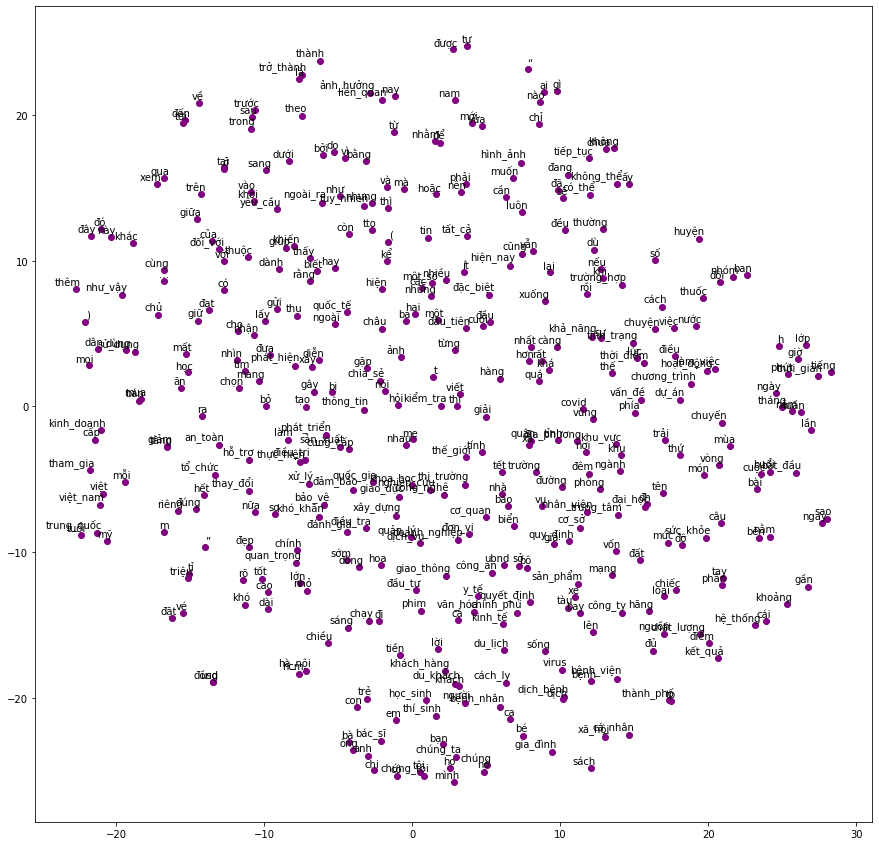

In [95]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y, color='purple')
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)